In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from scipy.stats import mannwhitneyu as MWU
from math import log

In [2]:
greg = {}

greg['Dre'] = pd.read_csv("./data/genomic_regions/intergenics_Dre.tsv.gz", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','gene1','gene2']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("./data/genomic_regions/intergenics_Bla.tsv.gz", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','gene1','gene2']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("./data/genomic_regions/intergenics_Ola.tsv.gz", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','gene1','gene2']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("./data/genomic_regions/intergenics_Mmu.tsv.gz", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','gene1','gene2']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Mmu', 18814), ('Bla', 18943), ('Dre', 19837), ('Ola', 15473)]


In [3]:
stages = {}
stages['Bla'] = ['15']
stages['Dre'] = ["8som"]
stages['Ola'] = ["8som"]

In [4]:
genome_size = {'Dre': 1.37e9,
              'Bla' : 0.5e9,
              'Ola' : 0.87e9}
rep_regions = {'Dre' : 716927489,
              'Bla' : 152452412,
               'Ola': 23221380
              }
avail_genome = { k:genome_size[k]-rep_regions[k] for k in ['Dre','Bla','Ola']  }
avail_genome

{'Bla': 347547588.0, 'Dre': 653072511.0, 'Ola': 846778620.0}

In [5]:
cov_table = pd.DataFrame()
fp_table = pd.DataFrame()
readnumf = lambda x: int(re.findall(r"_[0-9]+_", x)[0][1:-1])

Bla_coverage = 9200000*1000/ avail_genome['Bla']

In [6]:
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/medaka_{}_*_idr01Peaks.bed.gz'
readnumf = lambda x: int(re.findall(r"_[0-9]+_", x)[0][1:-1])
stage = '8som'
li = []
oli = []
for readnum,fp in sorted([(readnumf(x),x) for x in glob(stringu.format(stage))]):
    cov = readnum*1000/avail_genome['Ola']
    cov = round(cov*100 / Bla_coverage,2)

    li.append((readnum, cov))
    oli.append((readnum, fp))

cov_table['Ola'] = pd.Series(dict(li))
fp_table['Ola'] = pd.Series(dict(oli))   

In [7]:
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_{}_*_idr01Peaks.bed.gz'

stage = '8som'
li = []
oli = []
for readnum,fp in sorted([(readnumf(x),x) for x in glob(stringu.format(stage))]):
    cov = readnum*1000/avail_genome['Dre']
    cov = round(cov*100 / Bla_coverage,2)
    li.append((readnum, cov))
    oli.append((readnum, fp))

cov_table['Dre'] = pd.Series(dict(li))
fp_table['Dre'] = pd.Series(dict(oli))        

In [8]:
ola_picks = [
        [0,200000],
        [10, 2200000],
    [20,4600000],
    [30,6600000],
    [40,8800000],
    [50,11200000],
    [60,13200000],
    [70,15400000],
    [80,17800000],
    [90,20000000],
    [100,22200000]    
]

In [9]:
dre_picks = [
        [0,200000],
        [10,1800000],
    [20,3400000],
    [30,5200000],
    [40,7000000],
    [50,8600000],
    [60,10400000],
    [70,12200000],
    [80,13800000],
    [90,15600000],
    [100,17400000]    
]

In [20]:
# pd.set_option('display.max_rows', 200)


In [10]:
org = "zebra_danRer10"
stage='8som'
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_{}_{{}}_idr01Peaks.bed.gz'.format(stage)
greg_ = BT().from_dataframe(greg['Dre']).sort()


cols = ['chrom','start','end','gene1','gene2','size']
for pc, readn in dre_picks:
    cols.append( pc )
    greg_ = greg_.intersect(b=BT( stringu.format(readn) ), nonamecheck=True, c=True)
counts_Dre = greg_.to_dataframe(names=cols)

dre_melt1 = pd.melt(counts_Dre[['gene1']+cols[6:]], id_vars='gene1')
dre_melt1.columns = ['gene','pc','count']

dre_melt2 = pd.melt(counts_Dre[['gene2']+cols[6:]], id_vars='gene2')
dre_melt2.columns = ['gene','pc','count']

dre_melt = pd.concat([dre_melt1,dre_melt2]).groupby(['gene','pc']).sum().reset_index(drop=False)

dre_melt.head()

,gene,pc,count
0,ENSDARG00000000001,0,0
1,ENSDARG00000000001,10,0
2,ENSDARG00000000001,20,0
3,ENSDARG00000000001,30,0
4,ENSDARG00000000001,40,0


In [11]:
org = "medaka"
stage='8som'
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/medaka_{}_{{}}_idr01Peaks.bed.gz'.format(stage)
greg_ = BT().from_dataframe(greg['Ola']).sort()


cols = ['chrom','start','end','gene1','gene2','size']
for pc, readn in ola_picks:
    cols.append( pc )
    greg_ = greg_.intersect(b=BT( stringu.format(readn) ), nonamecheck=True, c=True)
counts_Ola = greg_.to_dataframe(names=cols)

ola_melt1 = pd.melt(counts_Ola[['gene1']+cols[6:]], id_vars='gene1')
ola_melt1.columns = ['gene','pc','count']

ola_melt2 = pd.melt(counts_Ola[['gene2']+cols[6:]], id_vars='gene2')
ola_melt2.columns = ['gene','pc','count']

ola_melt = pd.concat([ola_melt1,ola_melt2]).groupby(['gene','pc']).sum().reset_index(drop=False)

ola_melt.head()

,gene,pc,count
0,ENSORLG00000000002,0,0
1,ENSORLG00000000002,10,1
2,ENSORLG00000000002,20,2
3,ENSORLG00000000002,30,2
4,ENSORLG00000000002,40,2


In [12]:
org = "bla"
stage='15'

stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/amphi_15_9200000_idr01Peaks.bed.gz'

greg_ = BT().from_dataframe(greg['Bla']).sort()
cols = ['chrom','start','end','gene1','gene2','size','count']
greg_ = greg_.intersect(b=BT( stringu ), nonamecheck=True, c=True)
counts_Bla = greg_.to_dataframe(names=cols)

a = counts_Bla[['gene1','count']]
a.columns = ['gene','count']
b = counts_Bla[['gene2','count']]
b.columns = ['gene','count']
bla_melt = pd.concat([a,b]).groupby('gene').sum().reset_index()
bla_melt['pc'] = 100

In [89]:
bla_melt.head()

,gene,count,pc
0,BL00000,6,100
1,BL00001,17,100
2,BL00002,6,100
3,BL00003,3,100
4,BL00004,11,100


In [94]:
ola_melt['species'] = 'ola'
bla_melt['species'] = 'bla'
dre_melt['species'] = 'dre'

In [95]:
bigmelt = pd.concat([ola_melt, dre_melt,bla_melt])

(0, 30)

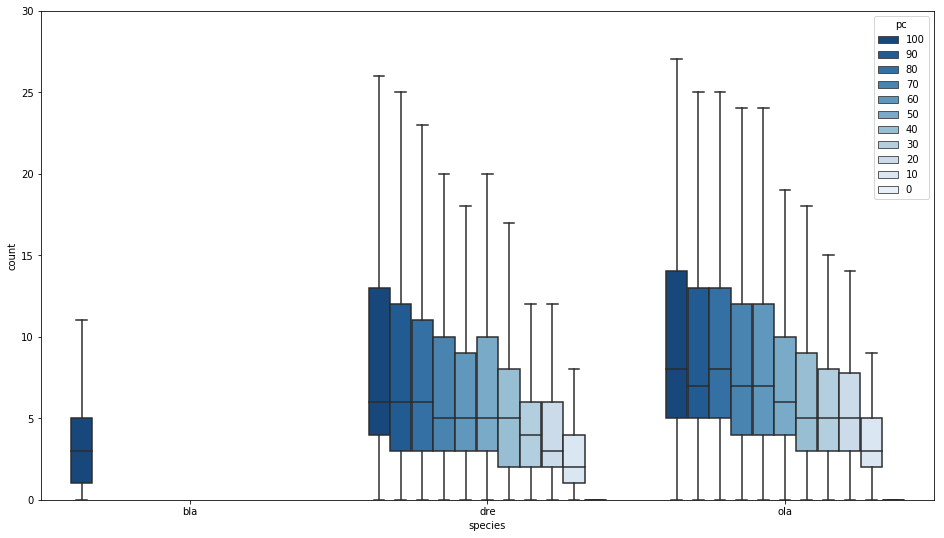

In [134]:
plt.figure(figsize=(16,9))



sns.boxplot(
    data=bigmelt,
    
    x = 'species',
    order= ['bla','dre','ola'],
    hue='pc',
    hue_order=[100,90,80,70,60,50,40,30,20,10,0],
    
    fliersize=0,
    y='count',
    palette='Blues_r'
)

plt.ylim((0,30))

In [112]:
lot = []
blavals = bigmelt.loc[bigmelt.species=='bla','count'].values

for gn,g in bigmelt.groupby(['species','pc']):
    species,pc = gn
    print( species, pc, MWU( g['count'].values , blavals, alternative='greater' ).pvalue)

('bla', 100, 0.50000017705446498)
('dre', 0, 1.0)
('dre', 10, 0.99999996100039212)
('dre', 20, 4.7463240998998108e-186)
('dre', 30, 8.1766798676516523e-251)
('dre', 40, 0.0)
('dre', 50, 0.0)
('dre', 60, 0.0)
('dre', 70, 0.0)
('dre', 80, 0.0)
('dre', 90, 0.0)
('dre', 100, 0.0)
('ola', 0, 1.0)
('ola', 10, 1.1264597682625321e-37)
('ola', 20, 0.0)
('ola', 30, 0.0)
('ola', 40, 0.0)
('ola', 50, 0.0)
('ola', 60, 0.0)
('ola', 70, 0.0)
('ola', 80, 0.0)
('ola', 90, 0.0)
('ola', 100, 0.0)


In [128]:
stringu = glob('/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/amphi_15_*_idr01Peaks.bed.gz')
readnumf = lambda x: re.findall(r"[0-9]+", x)[1]

In [130]:
sorted([readnumf(x) for x in stringu])

['1000000',
 '1200000',
 '1400000',
 '1600000',
 '1800000',
 '200000',
 '2000000',
 '2200000',
 '2400000',
 '2600000',
 '2800000',
 '3000000',
 '3200000',
 '3400000',
 '3600000',
 '3800000',
 '400000',
 '4000000',
 '4200000',
 '4400000',
 '4600000',
 '4800000',
 '5000000',
 '5200000',
 '5400000',
 '5600000',
 '5800000',
 '600000',
 '6000000',
 '6200000',
 '6400000',
 '6600000',
 '6800000',
 '7000000',
 '7200000',
 '7400000',
 '7600000',
 '7800000',
 '800000',
 '8000000',
 '8200000',
 '8400000',
 '8600000',
 '8800000',
 '9000000',
 '9200000']

In [44]:
dre_melt1 = pd.melt(counts_Dre[['gene1']+cols[6:]], id_vars='gene1')
dre_melt1.columns = ['gene','pc','count']

dre_melt2 = pd.melt(counts_Dre[['gene2']+cols[6:]], id_vars='gene2')
dre_melt2.columns = ['gene','pc','count']

dre_melt = pd.concat([dre_melt1,dre_melt2]).groupby(['gene','pc']).sum().reset_index(drop=False)

,gene,pc,count
0,ENSDARG00000000001,0,4
1,ENSDARG00000000001,10,4
2,ENSDARG00000000001,20,4
3,ENSDARG00000000001,30,4
4,ENSDARG00000000001,40,4
5,ENSDARG00000000001,50,4
6,ENSDARG00000000001,60,4
7,ENSDARG00000000001,70,4
8,ENSDARG00000000001,80,4
9,ENSDARG00000000001,90,4


gene     ENSDARG00000000001ENSDARG00000000001
pc                                          0
count                                       4
dtype: object

In [25]:
for pc, readn in dre_picks:
    break

In [28]:
stringu.format(readn)

'/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_200000_*_idr01Peaks.bed.gz'

In [ ]:
org = "zebra_danRer10"
stage='8som'
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_{}_{{}}_idr01Peaks.bed.gz'.format(stage)
greg_ = BT().from_dataframe(greg['Dre']).sort()
cols = ['chrom','start','end','gene1','gene2']


for readnum in cov_table.loc[cov_table['Dre']<22,['Dre']].index.values:
    cols.append( readnum )
    greg_ = greg_.intersect(b=BT( stringu.format(readnum) ).sort(), nonamecheck=True, c=True)
counts_Dre = greg_.to_dataframe(names=cols)

In [ ]:
cov_table.applymap(lambda x: round(x,2) )

In [ ]:
avail_genome

In [ ]:
# genefams[mask_oto]

In [ ]:
def dem_peaks(org,stage,coverage):
    eldict = {'zebra_danRer10':{21 : 14200000,
                15: 10400000,
                10: 7000000,
                5: 3800000},
            'amphi':{21 : 7600000,
                15: 5400000,
                10: 3800000,
                5: 2000000},
            'medaka':{21:18600000,
                15:13400000,
                10: 9200000,
                5: 5000000}}
    
    return '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/{}_{}_{}_idr01Peaks.bed.gz'.format(org, stage, eldict[org][coverage])

In [ ]:
li = glob('/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_24h_*_idr01Peaks.bed.gz')

In [ ]:
len('/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_24h_')

In [ ]:
cov_table = pd.DataFrame()
fp_table = pd.DataFrame()
readnumf = lambda x: int(re.findall(r"_[0-9]+_", x)[0][1:-1])

Bla_coverage = 9200000*1000/ avail_genome['Bla']

In [ ]:
cov_table

In [ ]:
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/medaka_{}_*_idr01Peaks.bed.gz'
readnumf = lambda x: int(re.findall(r"_[0-9]+_", x)[0][1:-1])
stage = '8som'
li = []
oli = []
for readnum,fp in sorted([(readnumf(x),x) for x in glob(stringu.format(stage))]):
    cov = readnum*1000/ avail_genome['Ola']
    cov = round(cov*100 / Bla_coverage,2)
    li.append((readnum, cov))
    oli.append((readnum, fp))

cov_table['Ola'] = pd.Series(dict(li))
fp_table['Ola'] = pd.Series(dict(oli))        

In [ ]:
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_{}_*_idr01Peaks.bed.gz'

stage = '8som'
li = []
oli = []
for readnum,fp in sorted([(readnumf(x),x) for x in glob(stringu.format(stage))]):
    cov = readnum*1000/ avail_genome['Dre']
    cov = round(cov*100 / Bla_coverage,2)

#     if cov <=22:
    li.append((readnum, cov))
    oli.append((readnum, fp))

cov_table['Dre'] = pd.Series(dict(li))
fp_table['Dre'] = pd.Series(dict(oli))        

In [ ]:
# cov_table[cov_table['Ola']<22]

In [ ]:
cov_table['Dre']

In [ ]:
org = "zebra_danRer10"
stage='8som'
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/zebra_danRer10_{}_{{}}_idr01Peaks.bed.gz'.format(stage)
greg_ = BT().from_dataframe(greg['Dre']).sort()
cols = ['chrom','start','end','gene1','gene2']


for readnum in cov_table.loc[cov_table['Dre']<22,['Dre']].index.values:
    cols.append( readnum )
    greg_ = greg_.intersect(b=BT( stringu.format(readnum) ).sort(), nonamecheck=True, c=True)
counts_Dre = greg_.to_dataframe(names=cols)

In [ ]:
org = "medaka"
stage='8som'
stringu = '/home/ska/panos/boxes/a_subsampling/FINAL/results/subsampledcalls/medaka_{}_{{}}_idr01Peaks.bed.gz'.format(stage)
greg_ = BT().from_dataframe(greg['Ola']).sort()
cols = ['chrom','start','end','gene1','gene2']

for readnum in cov_table.loc[cov_table['Ola']<22,['Ola']].index.values:
    cols.append( readnum )
    greg_ = greg_.intersect(b=BT( stringu.format(readnum) ).sort(), nonamecheck=True, c=True)
counts_Ola = greg_.to_dataframe(names=cols)

In [ ]:
org = "amphi"

greg_ = BT().from_dataframe(greg['Bla']).sort()
cols = ['chr','start','end','gene1','gene2']
stage = 15
coverage = 21

greg_ = greg_.intersect(b=BT(dem_peaks(org,stage,coverage)), nonamecheck=True, c=True)
cols.append(21)
counts_Bla = greg_.to_dataframe(names=cols)

In [ ]:
# mask_oton = (genefamsC['DANRE']==1)


In [ ]:
dre_picks = [round(x,2) for x in [1.458308,5.833233,10.208157,14.583081,20.416314,24.791238,30.624471,34.999395,40.832628,45.207552,49.582476, 55.415709 ,59.790633, 65.623866,69.998790,74.373715,80.206947,84.581872,90.415104,94.790028 ,
                 100.623261]]
Ola_picks = [  1.12, 5.62,
                10.12,  14.62, 
                20.24, 24.74,
                30.37,  34.87,
                40.49,  44.99,
                50.61,  55.11, 
                60.73,  65.23,
                69.73,  75.36,
                79.85,  85.48,
                89.98,  95.6, 
                100.1]

In [ ]:
def myround(x, base=5):
    return int(base * round(float(x)/base))

In [ ]:
melt_Dre = pd.melt(counts_Dre.loc[:,list(counts_Dre.columns[5:])])
melt_Dre['species'] = 'Dre'

In [ ]:
melt_Ola = pd.melt(counts_Ola.loc[:,list(counts_Ola.columns[5:])])
melt_Ola['species'] = 'Ola'

In [ ]:
Bla_count = counts_Bla[21].values

In [ ]:
Ola_glist = []
for readcount,gg in melt_Ola.groupby('variable'):
    ggc = gg.copy()
    cov = readcount*1000/846778620.0
    cov = round(cov*100/21.,2)
    if cov in Ola_picks[::2]:
        ggc['down'] = myround(cov)
        ggc['species'] = 'Ola'
        Ola_glist.append(ggc[['value','down','species']])
Ola_foo = pd.concat(Ola_glist)

In [ ]:
Dre_glist = []
for readcount,gg in melt_Dre.groupby('variable'):
    ggc = gg.copy()
    cov = readcount*1000/653072511.0
    cov = round(cov*100/21.,2)
    if cov in dre_picks[::2]:
        ggc['down'] = myround(cov)
        ggc['species'] = 'Dre'
        Dre_glist.append(ggc[['value','down','species']])
Dre_foo = pd.concat(Dre_glist)

In [ ]:
Bla_foo = pd.DataFrame(Bla_count)
Bla_foo.columns = ['value']
Bla_foo['species'] = 'Bla'
Bla_foo['down'] = 100

In [ ]:
big_foo = pd.concat([Dre_foo, Ola_foo, Bla_foo])

big_foo.head()
big_foo.columns = ['% of min. read coverage', 'species','value']

plt.rcParams['svg.fonttype'] = 'none'



plt.figure(figsize=(16,9))
sns.boxplot(data = big_foo, x='species', hue='% of min. read coverage', y='value',
           order = ['Bla','Dre','Ola'],
           palette = 'Blues_r', fliersize=0,
           hue_order=[100,90,80,70,60,50,40,30,20,10,0])

plt.ylim((0,15))
plt.legend(loc='upper left')


plt.savefig("")

In [ ]:
lot = []

Ola_glist = []
for readcount,gg in melt_Ola.groupby('variable'):
    ggc = gg.copy()
    cov = readcount*1000/846778620.0
    cov = round(cov*100/21.,2)
    if cov in Ola_picks[::2]:
        lot.append(( myround(cov), MWU(ggc.value.values, Bla_count, alternative='greater').pvalue ))

In [ ]:
Dre_glist = []
zlot = []
for readcount,gg in melt_Dre.groupby('variable'):
    ggc = gg.copy()
    cov = readcount*1000/653072511.0
    cov = round(cov*100/21.,2)
    if cov in dre_picks[::2]:
        zlot.append(( myround(cov), MWU(ggc.value.values, Bla_count, alternative='greater').pvalue ))

In [ ]:
pvalt = pd.merge(pd.DataFrame(lot),pd.DataFrame(zlot), on=0)
pvalt = pvalt.set_index(0, drop=True).sort_index(ascending=False)
pvalt.columns = ['Ola','Dre']
pvalt

In [ ]:
dre_table = pd.DataFrame()

plt.figure(figsize=(16,9))
for title,g in melt_Dre.groupby('gene_category'):
    
    titlelist = []
    if title not in titles:
        continue
    for readcount,gg in g.groupby('variable'):
        cov = readcount*1000/653072511.0
        pv = MWU(gg['value'].values, Bla_count_dist[title], alternative='greater').pvalue
        
        titlelist.append( (cov*100/21.,pv ) )
    x,y = zip(*titlelist)
    plt.plot( x,y, label=title)
    
    dre_table[title] = pd.Series(dict(titlelist))

    
title = 'all'
titlelist = []
for readcount,gg in melt_Dre[melt_Dre.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/653072511.0
    pv = MWU(gg['value'].values, np.concatenate(Bla_count_dist.values()), alternative='greater').pvalue
    titlelist.append( (cov*100/21., pv ) )
    

x,y = zip(*titlelist)
plt.plot( x,y, label=title, linewidth=2,linestyle='--')
dre_table[title] =  pd.Series(dict(titlelist))
    
    
plt.xlabel('% of minimum coverage')
plt.ylabel('p val: Do zebrafish genes have more peaks than amphi @ minCoverage?')
plt.title('Zebrafish')
# plt.ylim((0,10))
# plt.axhline((1.3))
plt.legend()

In [ ]:
Ola_table = pd.DataFrame()

plt.figure(figsize=(16,9))
for title,g in melt_Ola.groupby('gene_category'):
    
    titlelist = []
    if title not in titles:
        continue
    for readcount,gg in g.groupby('variable'):
        cov = readcount*1000/846778620.0
        pv = MWU(gg['value'].values, Bla_count_dist[title], alternative='greater').pvalue
        
        titlelist.append( (cov*100/21.,pv ) )
    x,y = zip(*titlelist)
    plt.plot( x,y, label=title)
    
    Ola_table[title] = pd.Series(dict(titlelist))

    
title = 'all'
titlelist = []
for readcount,gg in melt_Ola[melt_Ola.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/846778620.0
    pv = MWU(gg['value'].values, np.concatenate(Bla_count_dist.values()), alternative='greater').pvalue
    titlelist.append( (cov*100/21., pv ) )
    

x,y = zip(*titlelist)
plt.plot( x,y, label=title, linewidth=2,linestyle='--')
Ola_table[title] =  pd.Series(dict(titlelist))
    
    
plt.xlabel('% of minimum coverage')
plt.ylabel('p val: Do medaka genes have more peaks than amphi @ minCoverage?')
plt.title('Medaka')
# plt.ylim((0,10))
# plt.axhline((1.3))
plt.legend()

In [ ]:
Ola_table.to_csv("./downsampling_tables_Nov_Ola.tsv", sep='\t')
dre_table.to_csv("./downsampling_tables_Nov_dre.tsv", sep='\t')

In [ ]:
dre_table.index = dre_table.index.to_series().round(2)

In [ ]:
Ola_table.index = Ola_table.index.to_series().round(2)

In [ ]:
samplepoints = [1,10,20,30,40,50,60,70,80,90,100]
samplepointslight = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

dre_picks = [round(x,2) for x in [1.458308,5.833233,10.208157,14.583081,20.416314,24.791238,30.624471,34.999395,40.832628,45.207552,49.582476, 55.415709 ,59.790633, 65.623866,69.998790,74.373715,80.206947,84.581872,90.415104,94.790028 ,
                 100.623261]]

In [ ]:
dre_picks

In [ ]:

for title,column in Ola_table[Ola_table.index.to_series().apply(round).isin(samplepoints)].iteritems():
    plt.plot(column.index, column.values, label=title)
plt.title('Medaka: every 10%')
plt.legend()

plt.figure()
for title,column in Ola_table[Ola_table.index.to_series().apply(round).isin(samplepointslight)].iteritems():
    plt.plot(column.index, column.values, label=title)
plt.title('Medaka: every 5%')
plt.legend()

In [ ]:
drem = dre_table.loc[dre_picks[::2],['all']]
drem.index = drem.index.to_series().apply(myround)

In [ ]:
Olam = Ola_table.loc[Ola_picks[::2],['all']]
Olam.index = Olam.index.to_series().apply(myround)

In [ ]:
title = 'all'
Ola_glist = []
for readcount,gg in melt_Ola[melt_Ola.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/846778620.0
    cov = round(cov*100/21.,2)
    if cov in Ola_picks[::2]:
        gg['down'] = myround(cov)
        gg['species'] = 'Ola'
        Ola_glist.append(gg[['value','down','species']])

In [ ]:
title = 'all'
dre_glist = []
for readcount,gg in melt_Dre[melt_Dre.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/653072511.0
    cov = round(cov*100/21.,2)
    if cov in dre_picks[::2]:
        gg['down'] = myround(cov)
        gg['species'] = 'Dre'
        dre_glist.append(gg[['value','down','species']])

In [ ]:
Ola_foo = pd.concat(Ola_glist)
Dre_foo = pd.concat(dre_glist)

In [ ]:
Bla_foo = pd.DataFrame(counts_Bla.loc[counts_Bla.gene_category!='.',21].values)
Bla_foo.columns = ['value']
Bla_foo['species'] = 'Bla'
Bla_foo['down'] = 100

In [ ]:
big_foo = pd.concat([Dre_foo, Ola_foo, Bla_foo])

big_foo.head()
big_foo.columns = ['% of min. read coverage', 'species','value']

plt.rcParams['svg.fonttype'] = 'none'



plt.figure(figsize=(16,9))
sns.boxplot(data = big_foo, x='species', hue='% of min. read coverage', y='value',
           order = ['Bla','Dre','Ola'],
           palette = 'Blues_r', fliersize=0,
           hue_order=[100,90,80,70,60,50,40,30,20,10,0])

plt.ylim((0,25))
plt.savefig("/home/ska/panos/paper_figures/Nov15_downsampling_boxplot.svg",transparent=True)

In [ ]:
plt.figure(figsize=(16,9))


column = Ola_table.loc[Ola_picks,'all'] + 1e-237
plt.plot(column.index, [x for x in column.values], label='medaka')

column = dre_table.loc[dre_picks,'all']
plt.plot(column.index, [x for x in column.values], label='zebra')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


plt.legend()
plt.savefig("/home/ska/panos/paper_figures/Nov15_downsampling_lineplot.svg",transparent=True)

In [ ]:
fool = pd.concat( [Ola_table.loc[Ola_picks,'all'].reset_index(drop=True),dre_table.loc[dre_picks,'all'].reset_index(drop=True)] , axis=1)

fool.index= Ola_table.loc[Ola_picks,'all'].index.to_series().apply(myround).values

fool.columns = ['Ola','Dre']


In [ ]:
fool.sort_index(ascending=False).to_csv("/home/ska/panos/paper_figures/Nov15_downsampling_table.tsv",sep='\t')

In [ ]:
plt.figure(figsize=(16,9))


column = Ola_table.loc[Ola_picks,'all'] + 1e-237
plt.plot(column.index, [x for x in column.values], label='medaka')

column = dre_table.loc[dre_picks,'all']
plt.plot(column.index, [x for x in column.values], label='zebra')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.gca().set_yscale('log')

plt.ylim((100,1e-250))

plt.legend()

In [ ]:
plt.figure(figsize=(16,9))
for title,g in melt_Ola.groupby('gene_category'):
    
    titlelist = []
    if title not in titles:
        continue
    for readcount,gg in g.groupby('variable'):
        cov = readcount*1000/846778620.0
        pv = MWU(gg['value'].values, Bla_count_dist[title], alternative='greater').pvalue
        
        titlelist.append( (cov/21.,-log(pv+1e-300,10) ) )
    x,y = zip(*titlelist)
    plt.plot( np.array(x)*100,y, label=title)

    
title = 'all'
titlelist = []
for readcount,gg in melt_Ola[melt_Ola.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/846778620.0
    pv = MWU(gg['value'].values, np.concatenate(Bla_count_dist.values()), alternative='greater').pvalue
    titlelist.append( (cov/21.,-log(pv+1e-300,10) ) )
x,y = zip(*titlelist)
plt.plot( np.array(x)*100,y, label=title, linewidth=2,linestyle='--')

    
    
plt.axhline((0.05))
plt.xlabel('% of minimum coverage')
plt.ylabel('p val: Do zebrafish genes have more peaks than amphi @ minCoverage?')
plt.title('Medaka')
plt.legend()

In [ ]:
mask_oto = (genefamsC['Bla']==1) & (genefamsC['Dre']==1)
mask_ottw = (genefamsC['Bla']==1) & (genefamsC['Dre']==2)
mask_otth = (genefamsC['Bla']==1) & (genefamsC['Dre']==3)
mask_otfo = (genefamsC['Bla']==1) & (genefamsC['Dre']==4)

masks = [mask_oto, mask_ottw,mask_otth,mask_otfo]
titles = ['1-1','1-2','1-3','1-4']


counts_Dre['gene_category'] = '.'
for mask,title in zip(masks,titles):
    counts_Dre.loc[counts_Dre['geneID'].isin(reduce(add, genefams.loc[mask,'Dre'].dropna())),'gene_category'] = title

counts_Bla['gene_category'] = '.'
for mask,title in zip(masks,titles):
    counts_Bla.loc[counts_Bla['geneID'].isin(reduce(add, genefams.loc[mask,'Bla'].dropna())),'gene_category'] = title

In [ ]:
Bla_count_dist = { tit:counts_Bla.loc[counts_Bla['gene_category']==tit,21].values for tit in titles}

In [ ]:
melt_Dre = pd.melt(counts_Dre.loc[:,['gene_category'] + list(counts_Dre.columns[6:-1])], id_vars=['gene_category'])
melt_Dre.head()

In [ ]:
plt.figure(figsize=(16,9))
for title,g in melt_Dre.groupby('gene_category'):
    
    titlelist = []
    if title not in titles:
        continue
    for readcount,gg in g.groupby('variable'):
        cov = readcount*1000/653072511.0
        pv = MWU(gg['value'].values, Bla_count_dist[title], alternative='greater').pvalue
        
        titlelist.append( (cov/21.,pv ) )
    x,y = zip(*titlelist)
    plt.plot( np.array(x)*100,y, label=title)

    
title = 'all'
titlelist = []
for readcount,gg in melt_Dre[melt_Dre.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/653072511.0
    pv = MWU(gg['value'].values, np.concatenate(Bla_count_dist.values()), alternative='greater').pvalue
    titlelist.append( (cov/21., pv ) )
x,y = zip(*titlelist)
plt.plot( np.array(x)*100,y, label=title, linewidth=2,linestyle='--')

    
    
plt.xlabel('% of minimum coverage')
plt.ylabel('p val: Do zebrafish genes have more peaks than amphi @ minCoverage?')
plt.title('Zebrafish')
# plt.ylim((0,10))
plt.axhline((0.05))
plt.legend()

In [ ]:
mask_oto = (genefamsC['Bla']==1) & (genefamsC['Ola']==1)
mask_ottw = (genefamsC['Bla']==1) & (genefamsC['Ola']==2)
mask_otth = (genefamsC['Bla']==1) & (genefamsC['Ola']==3)
mask_otfo = (genefamsC['Bla']==1) & (genefamsC['Ola']==4)

masks = [mask_oto, mask_ottw,mask_otth,mask_otfo]
titles = ['1-1','1-2','1-3','1-4']

counts_Ola['gene_category'] = '.'
for mask,title in zip(masks,titles):
    counts_Ola.loc[counts_Ola['geneID'].isin(reduce(add, genefams.loc[mask,'Ola'].dropna())),'gene_category'] = title

counts_Bla['gene_category'] = '.'
for mask,title in zip(masks,titles):
    counts_Bla.loc[counts_Bla['geneID'].isin(reduce(add, genefams.loc[mask,'Bla'].dropna())),'gene_category'] = title
    
Bla_count_dist = { tit:counts_Bla.loc[counts_Bla['gene_category']==tit,21].values for tit in titles}

melt_Ola = pd.melt(counts_Ola.loc[:,['gene_category'] + list(counts_Ola.columns[6:-1])], id_vars=['gene_category'])
melt_Ola.head()

In [ ]:
plt.figure(figsize=(16,9))
for title,g in melt_Ola.groupby('gene_category'):
    
    titlelist = []
    if title not in titles:
        continue
    for readcount,gg in g.groupby('variable'):
        cov = readcount*1000/846778620.0
        pv = MWU(gg['value'].values, Bla_count_dist[title], alternative='greater').pvalue
        
        titlelist.append( (cov/21.,pv ) )
    x,y = zip(*titlelist)
    plt.plot( np.array(x)*100,y, label=title)

    
title = 'all'
titlelist = []
for readcount,gg in melt_Ola[melt_Ola.gene_category!='.'].groupby('variable'):
    cov = readcount*1000/846778620.0
    pv = MWU(gg['value'].values, np.concatenate(Bla_count_dist.values()), alternative='greater').pvalue
    titlelist.append( (cov/21.,pv ) )
x,y = zip(*titlelist)
plt.plot( np.array(x)*100,y, label=title, linewidth=2,linestyle='--')

    
    
plt.axhline((0.05))
plt.xlabel('% of minimum coverage')
plt.ylabel('p val: Do zebrafish genes have more peaks than amphi @ minCoverage?')
plt.title('Medaka')
plt.legend()

In [ ]:
# o = ['Bla_8','Bla_15','Bla_36','Bla_60',' ',
#     'Dre_dome','Dre_shield','Dre_80epi','Dre_8som','Dre_24h','Dre_48h',' ',
#     'Ola_dome','Ola_shield','Ola_8som','Ola_24h','Ola_48h']


# lot = {}
# lot['Dre'] = []
# lot['Bla'] = []
# lot['Ola'] = []

# for mask,title in zip(masks, titles):
#     for i,row in genefams.loc[mask,['Bla','Dre','Mmu','Xtr','Ola']].iterrows():
#         for spec in ['Bla','Dre','Ola']:
#             try:
#                 lgl = row[spec]
#                 if lgl == lgl:
#                     slaice = CW[spec].ix[lgl, 5:].copy()
#                     slaice['title'] = title
#                     lot[spec].append( slaice)
#             except:
#                 pass



In [ ]:
lot['Dre'] = pd.concat(lot['Dre'])
lot['Bla'] = pd.concat(lot['Bla'])
lot['Ola'] = pd.concat(lot['Ola'])


Dre_melt = pd.melt( lot['Dre'],id_vars='title' )
Dre_melt.variable = "Dre_" + Dre_melt.variable

Bla_melt = pd.melt( lot['Bla'],id_vars='title' )
Bla_melt.variable = "Bla_" + Bla_melt.variable

Ola_melt = pd.melt( lot['Ola'],id_vars='title' )
Ola_melt.variable = "Ola_" + Ola_melt.variable

bigmelt1 = pd.concat([Dre_melt, Bla_melt, Ola_melt])


In [ ]:
melty = bigmelt1.copy()
melty['Coverage'] = melty.variable.apply(lambda x: x.split(":")[1] )
melty['SpecStage'] = melty.variable.apply(lambda x: x.split(":")[0] )
melty.head()

In [ ]:
lom = pd.concat([
melty.loc[(melty.SpecStage=='Bla_15') & (melty.Coverage=='21'),:],
melty.loc[(melty.SpecStage=='Dre_8som'),:],
melty.loc[(melty.SpecStage=='Ola_8som'),:]
])

stageorder = ['Bla_15:21','Dre_8som:5','Dre_8som:10','Dre_8som:15','Dre_8som:21','Ola_8som:5','Ola_8som:10','Ola_8som:15','Ola_8som:21']


sns.set_style("white")
# fig, ax = plt.subplots(figsize=(3,9))

# mpal = {"Bla_15":"#0072b2",
#        "Dre_8som":"#0072b2",
#        "Ola_8som":"#0072b2"}

plt.figure(figsize=(16,9))
ax = sns.boxplot(
           data= lom,
           y = "value",
           x='variable',
           order=stageorder,
           fliersize=0,
           
           palette='Blues'
           )

ax.set(ylim=(0,24))

_ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)


ell = [(1, 1.0, 8.0),
    (2,5.27e-53, 16.0),
    (3,1.56e-122, 17.0),
    (4,5.67e-218, 19.0),
    (5,1.36e-33, 9.0),
    (6,3.09e-183, 14.0),
    (7,0.0, 18.0),
    (8,0.0, 23.0)]

for e,p,y in ell:
    ax.text( e, y+0.2, p, ha='center', va='bottom', color=col)

# plt.savefig("/home/ska/panos/paper_figures/daltons_Aug10_BlaDreola_Phylotypic_DownSampling.pdf",
#             transparent=True)
# plt.savefig("/home/ska/panos/paper_figures/daltons_Aug10_BlaDreola_Phylotypic_DownSampling.png",
#             transparent=False)

In [ ]:
groups = [g for gn,g in lom.groupby('variable')]
names = [gn for gn,g in lom.groupby('variable')]
for i in range(1,len(groups)):
    buz = groups[i].dropna().value.values
    Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
    hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max()
    print(names[i], MWU(buz, groups[0].value.values, alternative='greater').pvalue, hival)
    

In [ ]:
np.percentile(buz, 75)

In [ ]:
g = groups[1]


In [ ]:
h, col = 1, 'k'

o_i1 = ['Bla_15',
    'Dre_8som',
    'Ola_8som']


sns.set_style("white")
# fig, ax = plt.subplots(figsize=(3,9))

mpal = {"Bla_15":"#0072b2",
       "Dre_8som":"#0072b2",
       "Ola_8som":"#0072b2"}

bp = sns.factorplot(
           kind="box",
           data= melty,
           y = "value",
           x='SpecStage',
           order=o_i1,
           col="Coverage",
           col_order = ['5','10','15','21'],
           fliersize=0,
            palette=mpal,
            
            size=8, aspect=0.5,
            
           )

bp.set(ylim=(0,30))


pvals = [[MWU( melty.loc[(melty.Coverage==cov) & (melty.SpecStage=='Dre_8som'),'value' ].values,
             melty.loc[(melty.Coverage==cov) & (melty.SpecStage=='Bla_15'),'value' ].values,
             alternative='greater').pvalue,
         MWU( melty.loc[(melty.Coverage==cov) & (melty.SpecStage=='Ola_8som'),'value' ].values,
             melty.loc[(melty.Coverage==cov) & (melty.SpecStage=='Bla_15'),'value' ].values,
             alternative='greater').pvalue] for cov in ['5','10','15','21']]
pvals = [["{:.2e}".format(x[0]),"{:.2e}".format(x[1])] for x in pvals]
pvals
ys = [[10,13],[18,20],[18,20],[22,25]]


x1=0
for e,axis in enumerate(bp.axes[0]):
    y1,y2=ys[e]
    t1,t2 = pvals[e]
    x2=1
    axis.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1, c=col)
    axis.text((x1+x2)*.5, y1+h, t1, ha='center', va='bottom', color=col)
    x2=2
    axis.plot([x1, x1, x2, x2], [y2, y2+h, y2+h, y2], lw=1, c=col)
    axis.text((x1+x2)*.5, y2+h, t2, ha='center', va='bottom', color=col)


# plt.savefig("/home/ska/panos/paper_figures/daltons_Aug10_BlaDreola_Phylotypic_DownSampling.pdf",
#             transparent=True)
# plt.savefig("/home/ska/panos/paper_figures/daltons_Aug10_BlaDreola_Phylotypic_DownSampling.png",
#             transparent=False)

In [ ]:
o_i1 = ['Bla_15',
    'Dre_8som',
    'Ola_8som']


sns.set_style("white")
# fig, ax = plt.subplots(figsize=(3,9))

# mpal = {"Bla_15":"#0072b2",
#        "Dre_8som":"#0072b2",
#        "Ola_8som":"#0072b2"}

bp = sns.factorplot(
           kind="box",
           data= melty,
           y = "value",
           x='SpecStage',
            hue='title',
           order=o_i1,
           row="Coverage",
           row_order = ['5','10','15','21'],
           fliersize=0,
            palette='Blues',
            
            size=8, aspect=0.65,
            
           )

bp.set(ylim=(0,30))



m5 = melty.Coverage =='5'
m10 = melty.Coverage =='10'
m15 = melty.Coverage =='15'
m21 = melty.Coverage =='21'

dre = melty.SpecStage=='Dre_8som'
bla = melty.SpecStage=='Bla_15'
ola = melty.SpecStage=='Ola_8som'

ma = melty.title == '1-1'
mb = melty.title == '1-2'
mc = melty.title == '1-3'
md = melty.title == '1-4'

pvals = [["{:.2e}".format(x) for x in 
[MWU(melty.loc[dre & mcov & ma, 'value'].values, melty.loc[bla & mcov & ma, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[dre & mcov & mb, 'value'].values, melty.loc[bla & mcov & mb, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[dre & mcov & mc, 'value'].values, melty.loc[bla & mcov & mc, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[dre & mcov & md, 'value'].values, melty.loc[bla & mcov & md, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[ola & mcov & ma, 'value'].values, melty.loc[bla & mcov & ma, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[ola & mcov & mb, 'value'].values, melty.loc[bla & mcov & mb, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[ola & mcov & mc, 'value'].values, melty.loc[bla & mcov & mc, 'value'].values, alternative='greater').pvalue,
MWU(melty.loc[ola & mcov & md, 'value'].values, melty.loc[bla & mcov & md, 'value'].values, alternative='greater').pvalue]]
for mcov in [m5,m10,m15,m21]]


xs = [0.7,0.9, 1.1, 1.3, 1.7,1.9, 2.1, 2.3]

yss = [[7,9,12,14,8.5,10,13,15],
[12,16,19,21,13,18,19,20],
[13,18,24,24,18,21,26,26],
[15,20,26,26,19,24,30,28]]
h, col = 1, 'k'
for e,axis in enumerate(bp.axes):
    axis = axis[0]
    ys = yss[e]
#     y1,y2=ys[e]
    texts = pvals[e]
      
    for t1,x1,y1 in zip(texts,xs,ys):
        axis.text(x1, y1, t1, ha='center', va='bottom', color=col, rotation=90)
    

# plt.savefig("/home/ska/panos/paper_figures/daltons_Sept_BlaDreola_Phylotypic_GeneFams_DownSampling.svg", transparent=True)
# plt.savefig("/home/ska/panos/paper_figures/daltons_Aug10_BlaDreola_Phylotypic_GeneFams_DownSampling.png", transparent=False)